<a href="https://colab.research.google.com/github/justdenz/mco2-technical-report/blob/main/Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
sns.set(font_scale=1.2)

sns.set_style("darkgrid")

from datetime import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.graphics as smg
import statsmodels.stats as sm_stats
import statsmodels.tsa.api as tsa

from scipy import stats


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import re
from typing import List

# Dataset
GitHub Commit Messages Dataset 

https://www.kaggle.com/dhruvildave/github-commit-messages-dataset

Downloading the **modified** Github Commit Messages Dataset

In [ ]:
!gdown https://drive.google.com/uc?id=1IT4IdOhTu3e6StB76iVAVBH4lnrvf_ys
# !gdown https://drive.google.com/uc?id=1YuyNK-idGHj1-ltmGkRtok7ml7pP6c6E
# !unzip github.zip

Downloading...
From: https://drive.google.com/uc?id=1IT4IdOhTu3e6StB76iVAVBH4lnrvf_ys
To: /content/github_categories.csv
2.50GB [00:23, 105MB/s] 


To determine what type of commit a message is, we had to **modify** the original dataset. Using this [reference](https://www.kaggle.com/amarabuco/commits-eda#Commit-Classification), we added the ‘category’ column, which corresponds to the commit type by running the commit message through a series of regex and keyword matching functions run sequentially, not parallel. With this, we were able to categorize the commits into 5 categories of commit types:

*   Security - security breaches or compromises
*   Fix - fixes, failures, faults, errors
*   Refactor - remove, cleaning, reorganizing, polishing
*   Bug - core bugs
*   Other - additions, new features, updates, upgrades

Loading data from a CSV file into a Pandas DataFrame

In [ ]:
df = pd.read_csv('github_categories.csv', parse_dates=True, infer_datetime_format=True)

## Validating & Preprocessing Data

Preprocess format of date

In [ ]:
df['date'] = df['date'].apply(lambda x: dt.strptime(x,"%a %b %d %H:%M:%S %Y %z"))

In [ ]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [ ]:
df['dday'] = df['date'].dt.date
df['wday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df['min'] = df['date'].dt.minute
df['sec'] = df['date'].dt.second

Preprocess format of author, user, and email

In [ ]:
df = df.join(df['author'].str.split('(<)',n=2,expand=True ))

In [ ]:
df = df.drop('author', axis=1)
df = df.drop(1, axis=1)
df = df.rename({0:'user', 2:'email' }, axis=1)
df['email'] = df['email'].str.strip('>')

Display first 5 rows of dataFrame

In [ ]:
df.head()

,commit,date,message,repo,category,dday,wday,day,month,year,hour,min,sec,user,email
0,692bba578efb5e305c9b116568e5aad75b3fdbb3,2021-04-21 04:27:07+00:00,DOC: add example for plotting asymmetrical err...,pandas-dev/pandas,fix,2021-04-21,2,21,4,2021,4,27,7,Mortada Mehyar,mortada@users.noreply.github.com
1,855696cde0ef5d80a7d4bd3f6a2940c5a2fecb3f,2021-04-20 23:23:07+00:00,Add keyword sort to pivot_table (#40954),pandas-dev/pandas,other,2021-04-20,1,20,4,2021,23,23,7,Patrick Hoefler,61934744+phofl@users.noreply.github.com
2,eaaefd140289a5103679ac6748567f724c7be56a,2021-04-20 23:21:22+00:00,ENH: `Styler.highlight_quantile` method (#40926),pandas-dev/pandas,other,2021-04-20,1,20,4,2021,23,21,22,attack68,24256554+attack68@users.noreply.github.com
3,aab87997058f3c74ba70286620ebe792ee4ef169,2021-04-20 23:01:03+00:00,ENH: add `decimal` and `thousands` args to `St...,pandas-dev/pandas,other,2021-04-20,1,20,4,2021,23,1,3,attack68,24256554+attack68@users.noreply.github.com
4,9c43cd7675d96174051e470de1f45e2bf7c9ebdc,2021-04-20 22:58:18+00:00,[ArrowStringArray] Use utf8_upper and utf8_low...,pandas-dev/pandas,other,2021-04-20,1,20,4,2021,22,58,18,Simon Hawkins,simonjayhawkins@gmail.com


Print distinct years in dataFrame

In [ ]:
print(df['year'].unique())

[2021 2020 2019 2018 2015 2017 2016 2014 2013 2012 2011 2010 2009 2008
 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994
 1993 1992 1991 1990 1988 1974 1972 1989 2085 2037 2030 1970]


Filter commit messages from 1990 to 2020 only

In [ ]:
df = df[df.year >= 1990]
df = df[df.year <= 2020]

## Exploratory Data Analysis (EDA)

In [ ]:
repos = df['repo'].unique().tolist()
categories = df['category'].unique().tolist()

In [ ]:
red_clr = "#da4247"
orange_clr = "#f08f49"
green_clr = "#4dab8c"
blue_clr = "#3d7b9d"
violet_clr = "#72578e"

Display distinct repositories

In [ ]:
print("Number of Distinct Repositories: " + str(len(repos)))
repos

Display distinct categories

In [ ]:
print("Number of Distinct categories: " + str(len(categories)))
categories

Number of Distinct categories: 5


['other', 'fix', 'refactor', 'bug', 'security']

Display pie chart of commit messages by category for entire dataset

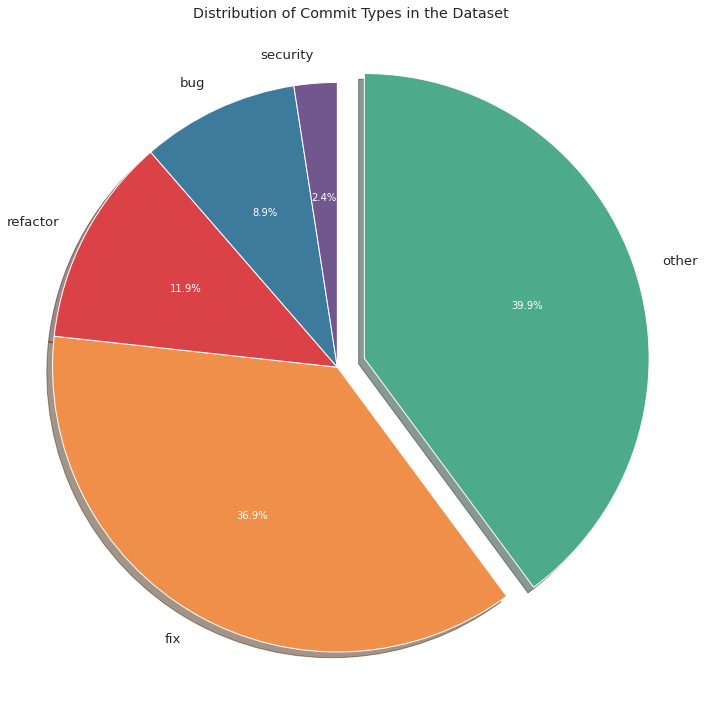

In [ ]:
category_labels = []
category_counts = []
colors = [green_clr, orange_clr, red_clr, blue_clr, violet_clr]

for category in categories:
  category_labels.append(category)
  category_counts.append(len(df[df.category == category]))

category_fig, category_ax = plt.subplots(figsize=(10, 10))

_, _, autotexts = category_ax.pie(category_counts, colors=colors, explode=(0.1, 0, 0, 0, 0), labels=category_labels, autopct='%1.1f%%', shadow=True, startangle=90, counterclock=False)

for autotext in autotexts:
    autotext.set_color('white')

category_ax.set_title('Distribution of Commit Types in the Dataset')
category_ax.axis('equal') 
plt.tight_layout()
plt.show()

Display number of commits for each repository

In [ ]:
ustats = df.groupby('repo').nunique()
ustats = ustats.sort_values(by="message", ascending=False)
ustats['message'].plot.bar(figsize=(20, 10))

Display number of commits for each repository (excluding torvald/linux and chromium/chromium)

In [ ]:
ustats.drop('torvalds/linux').drop('chromium/chromium').sort_values(by='message',ascending=False)['message'].plot.bar(figsize=(20, 10))

Display number of users for each repository

In [ ]:
ustats['user'].plot.bar(figsize=(20, 10))

Display number of users for each repository (excluding torvald/linux and chromium/chromium)

In [ ]:
ustats.drop('torvalds/linux').drop('chromium/chromium').sort_values(by='user',ascending=False)['user'].plot.bar(figsize=(20, 10))

Display number of commits and number of users for each unique repository

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,10))
fig.autofmt_xdate(rotation=90)
ax1.bar(x=ustats.index, height=ustats['message'])
ax1.set_title('Number of Commits')
ax2.bar(x=ustats.index, height=ustats['user'])
ax2.set_title('Number of Users')

### Scatterplots for Trend of Users vs Commits

In [ ]:
import datetime
dateparser = lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%a %b %d %H:%M:%S %Y %z"), utc=True)
p = 0.01 # number of rows in full file = 3240997
newdf = pd.read_csv('github_categories.csv', 
                     parse_dates=['date'], 
                     date_parser=dateparser, 
                     usecols=['author', 'date', 'repo', 'commit', 'message'],
                     # nrows=100,
                     skiprows=lambda i: i > 0 and random.random() > p
                    )

In [ ]:
newdf.dropna(subset=['message'], inplace=True)
user_commit_df = newdf.groupby('repo').nunique().sort_values('commit', ascending=False)[['commit', 'author']]
color = {}
for repo in set(df.repo):
    color[repo] = '#' + ''.join([random.choice('23456789ABCD') for j in range(6)])

Display scatterplot for number of unique users vs. number of commits

In [ ]:
scatter_fig, scatter_axis = plt.subplots(figsize=(10, 5))
scatter_axis.scatter(user_commit_df.commit, user_commit_df.author, c=[color[repo] for repo in user_commit_df.index])
scatter_axis.set_xlabel('Number of Commits', size=15)
scatter_axis.set_ylabel('Number of Users', size=15)
scatter_axis.set_title('Number of Unique Users vs. Number of Commits', size=15)
plt.show()

Display scatterplot for number of unique users vs. number of commits (excluding torvalds/linux and chromium/chromium)

In [ ]:
user_commit_df2 = user_commit_df.drop('torvalds/linux').drop('chromium/chromium')
scatter_fig2, scatter_axis2 = plt.subplots(figsize=(10, 5))
scatter_axis2.scatter(user_commit_df2.commit, user_commit_df2.author, c=[color[repo] for repo in user_commit_df2.index])
scatter_axis2.set_xlabel('Number of Commits', size=15)
scatter_axis2.set_ylabel('Number of Users', size=15)
scatter_axis2.set_title('Number of Unique Users vs. Number of Commits (without torvalds/linux and chromium/chromium)', size=15)
plt.show()

# Specific Questions

In [ ]:
sum_df = df.copy()

### What type of commits are made on certain times of the day?

In [ ]:
hour_array = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

Display number of commits by hour of day of each category across all repositories

In [ ]:
try_df = sum_df[['hour', 'category', 'commit', 'repo']]
dday_hour_cat_df = try_df.groupby(['repo', "hour", "category"]).count()
dday_hour_cat_df

Display average number of commits by hour of day of each category across all repositories 

In [ ]:
avg_cat_hour = dday_hour_cat_df.groupby(["hour", "category"]).agg({'commit':'mean'})
avg_cat_hour

Plot average total commits by hour of each category across all repositories.

In [ ]:
ax = sns.relplot(data=avg_cat_hour, x="hour", y='commit', hue="category", kind="line", height=12, aspect=1.5, linewidth = 5).set(xticks = hour_array)
ax.set(ylabel='Commits', xlabel='Hour of Day')
plt.title('Total Hourly Commit by Different Commit Types')
plt.show()

Create a stacked bar for viewing the total commit types and the different commit types.

In [ ]:
new_plt = plt

In [ ]:
hour_other_cats = try_df[try_df.category == "other"]
hour_refactor_cats = try_df[try_df.category == "refactor"]
hour_fix_cats = try_df[try_df.category == "fix"]
hour_bug_cats = try_df[try_df.category == "bug"]

In [ ]:
bottom1_bar_data = hour_other_cats
bottom1_bar_data = bottom1_bar_data.groupby(["repo","hour", "category"]).count()
bottom1_bar_data = bottom1_bar_data.groupby(["hour"]).agg({'commit':'sum'}).reset_index()
bottom1_bar_data

In [ ]:
bottom2_bar_data = pd.concat([hour_other_cats, hour_refactor_cats])
bottom2_bar_data = bottom2_bar_data.groupby(["repo","hour", "category"]).count()
bottom2_bar_data = bottom2_bar_data.groupby(["hour"]).agg({'commit':'sum'}).reset_index()
bottom2_bar_data

In [ ]:
bottom3_bar_data = pd.concat([hour_other_cats, hour_refactor_cats, hour_fix_cats])
bottom3_bar_data = bottom3_bar_data.groupby(["repo","hour", "category"]).count()
bottom3_bar_data = bottom3_bar_data.groupby(["hour"]).agg({'commit':'sum'}).reset_index()
bottom3_bar_data

In [ ]:
bottom4_bar_data = pd.concat([hour_other_cats, hour_refactor_cats, hour_fix_cats, hour_bug_cats])
bottom4_bar_data = bottom4_bar_data.groupby(["repo","hour", "category"]).count()
bottom4_bar_data = bottom4_bar_data.groupby(["hour"]).agg({'commit':'sum'}).reset_index()
bottom4_bar_data

In [ ]:
hour_total_cats = try_df.groupby(["repo","hour", "category"]).count()
hour_total_cats = hour_total_cats.groupby(["hour"]).agg({'commit':'sum'}).reset_index()
hour_total_cats

In [ ]:
hour_fig_dims = (12, 10)
hour_fig, hour_ax = new_plt.subplots(figsize=hour_fig_dims)
hour_ax.set_title('Total Hourly Commit with Different Commit Types')

hour_top_bar = sns.barplot(x="hour",  y="commit", data=hour_total_cats, color=violet_clr, ax=hour_ax)
hour_top_bar4 = sns.barplot(x="hour",  y="commit", data=bottom4_bar_data , color=blue_clr, ax=hour_ax)
hour_top_bar3 = sns.barplot(x="hour",  y="commit", data=bottom3_bar_data , color=orange_clr, ax=hour_ax)
hour_top_bar2 = sns.barplot(x="hour",  y="commit", data=bottom2_bar_data , color=red_clr, ax=hour_ax)
hour_top_bar1 = sns.barplot(x="hour",  y="commit", data=bottom1_bar_data , color=green_clr, ax=hour_ax)

hour_bar = mpatches.Patch(color=violet_clr, label='Security Commits')
hour_bar4 = mpatches.Patch(color=blue_clr, label='Bug Commits')
hour_bar3 = mpatches.Patch(color=orange_clr, label='Fix Commits')
hour_bar2 = mpatches.Patch(color=red_clr, label='Refactor Commits')
hour_bar1 = mpatches.Patch(color=green_clr, label='Others Commits')
new_plt.legend(handles=[hour_bar,hour_bar4,hour_bar3,hour_bar2,hour_bar1], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
new_plt.ylabel('Total Commits')
new_plt.xlabel('Hour of Day')
new_plt.show()

Display total hourly commit types for each repository

In [ ]:
new_plt = plt
for idx, repo in enumerate(df['repo'].unique()):
  try_df = sum_df[sum_df.repo == repo]
  try_df = try_df[['hour', 'category', 'commit', 'repo']]
  dday_hour_cat_df = try_df.groupby(['repo', "hour", "category"]).count()
  ax = sns.relplot(x="hour", y="commit", hue="category", kind="line", col="repo", data=dday_hour_cat_df, height=12, aspect=1.5, linewidth = 5).set(xticks = hour_array)
  ax.set(ylabel='Commits', xlabel='Hour of Day')
  new_plt.title(f'Total Hourly Commit by Different Commit Types for {repo}')
  new_plt.show()

Filter time frame for pre-pandemic and during pandemic

In [ ]:
def categorize_commit_pandemic(sample):
  if sample['year'] >= 2020:
    if sample['month'] >= 4:
      return 'during pandemic'
    else:
      return 'pre-pandemic'
  else:
    return 'pre-pandemic'

In [ ]:
timeframe_df = sum_df.copy()
timeframe_df = timeframe_df[['dday','hour', 'category', 'commit', 'year', 'month']]
timeframe_df['time_frame'] = timeframe_df.apply(categorize_commit_pandemic, axis=1)
timeframe_df

In [ ]:
pre_pandemic_timeframe_df = timeframe_df[timeframe_df.time_frame == "pre-pandemic"]
pre_pandemic_timeframe_df = pre_pandemic_timeframe_df.groupby(['dday',"hour", "time_frame"]).count()
pre_pandemic_timeframe_df = pre_pandemic_timeframe_df.groupby(["hour", "time_frame"]).agg({'commit':'mean'}).reset_index()
pre_pandemic_timeframe_df

In [ ]:
during_pandemic_timeframe_df = timeframe_df[timeframe_df.time_frame == "during pandemic"]
during_pandemic_timeframe_df = during_pandemic_timeframe_df.groupby(['dday',"hour", "time_frame"]).count()
during_pandemic_timeframe_df = during_pandemic_timeframe_df.groupby(["hour", "time_frame"]).agg({'commit':'mean'}).reset_index()
during_pandemic_timeframe_df

Study commit patterns throughout the day in pre-pandemic and during pandemic period.



In [ ]:
new_plt = plt
f, (ax1, ax2) = new_plt.subplots(1, 2, sharey=False,figsize=(30,10))


ax1.plot(pre_pandemic_timeframe_df.hour, pre_pandemic_timeframe_df.commit,  color='green')
ax1.set_xticks(hour_array)
ax1.set_title('Average Hourly Commit Pre-Pandemic')
ax1.set_ylabel('Average Hourly Commits')
ax1.set_xlabel('Hour of Day')

ax2.plot(during_pandemic_timeframe_df.hour, during_pandemic_timeframe_df.commit, color='orange')
ax2.set_xticks(hour_array)
ax2.set_title('Average Hourly Commit During Pandemic')
ax2.set_ylabel('Average Hourly Commits')
ax2.set_xlabel('Hour of Day')

new_plt.show()

### What type of commits are made on certain days of the week?

Legend:
*   0 - Monday
*   1 - Tuesday
*   2 - Wednesday
*   3 - Thursday
*   4 - Friday
*   5 - Saturday
*   6 - Sunday



In [ ]:
weekday_array = [0,1,2,3,4,5,6]

Display number of commits by day of week of each category across all repositories

In [ ]:
week_df = sum_df[["repo",'wday', 'category', 'commit']]
wday_cat_df = week_df.groupby(["repo","wday", "category"]).count()
wday_cat_df

Display average number of commits by day of week of each category across all repositories

In [ ]:
avg_cat_wday = wday_cat_df.groupby(["wday", "category"]).agg({'commit':'mean'})
avg_cat_wday

Display total day of week commit by different commit types

In [ ]:
ax = sns.relplot(data=avg_cat_wday, x="wday", y='commit', hue="category", kind="line", height=12, aspect=1.5, linewidth = 5).set(xticks = weekday_array)
ax.set(ylabel='Commits', xlabel='Hour of Day')
plt.title('Total Day of Week Commit by Different Commit Types')
plt.show()

Create a stacked bar for viewing the total commit types and the different commit types.

In [ ]:
new_plt = plt

In [ ]:
wday_other_cats = week_df[week_df.category == "other"]
wday_refactor_cats = week_df[week_df.category == "refactor"]
wday_fix_cats = week_df[week_df.category == "fix"]
wday_bug_cats = week_df[week_df.category == "bug"]

In [ ]:
bottom1_bar_data = wday_other_cats
bottom1_bar_data = bottom1_bar_data.groupby(["repo","wday", "category"]).count()
bottom1_bar_data = bottom1_bar_data.groupby(["wday"]).agg({'commit':'sum'}).reset_index()
bottom1_bar_data

In [ ]:
bottom2_bar_data = pd.concat([wday_other_cats, wday_refactor_cats])
bottom2_bar_data = bottom2_bar_data.groupby(["repo","wday", "category"]).count()
bottom2_bar_data = bottom2_bar_data.groupby(["wday"]).agg({'commit':'sum'}).reset_index()
bottom2_bar_data

In [ ]:
bottom3_bar_data = pd.concat([wday_other_cats, wday_refactor_cats, wday_fix_cats])
bottom3_bar_data = bottom3_bar_data.groupby(["repo","wday", "category"]).count()
bottom3_bar_data = bottom3_bar_data.groupby(["wday"]).agg({'commit':'sum'}).reset_index()
bottom3_bar_data

In [ ]:
bottom4_bar_data = pd.concat([wday_other_cats, wday_refactor_cats, wday_fix_cats, wday_bug_cats])
bottom4_bar_data = bottom4_bar_data.groupby(["repo","wday", "category"]).count()
bottom4_bar_data = bottom4_bar_data.groupby(["wday"]).agg({'commit':'sum'}).reset_index()
bottom4_bar_data

In [ ]:
wday_total_cats = week_df.groupby(["repo","wday", "category"]).count()
wday_total_cats = wday_total_cats.groupby(["wday"]).agg({'commit':'sum'}).reset_index()
wday_total_cats

In [ ]:
wday_fig_dims = (12, 10)
wday_fig, wday_ax = new_plt.subplots(figsize=wday_fig_dims)
wday_ax.set_title('Total Daily per Week Commit with Different Commit Types')
wday_top_bar = sns.barplot(x="wday",  y="commit", data=wday_total_cats, color=violet_clr, ax=wday_ax)
wday_top_bar4 = sns.barplot(x="wday",  y="commit", data=bottom4_bar_data , color=blue_clr, ax=wday_ax)
wday_top_bar3 = sns.barplot(x="wday",  y="commit", data=bottom3_bar_data , color=orange_clr, ax=wday_ax)
wday_top_bar2 = sns.barplot(x="wday",  y="commit", data=bottom2_bar_data , color=red_clr, ax=wday_ax)
wday_top_bar1 = sns.barplot(x="wday",  y="commit", data=bottom1_bar_data , color=green_clr, ax=wday_ax)

wday_bar = mpatches.Patch(color=violet_clr, label='Security Commits')
wday_bar4 = mpatches.Patch(color=blue_clr, label='Bug Commits')
wday_bar3 = mpatches.Patch(color=orange_clr, label='Fix Commits')
wday_bar2 = mpatches.Patch(color=red_clr, label='Refactor Commits')
wday_bar1 = mpatches.Patch(color=green_clr, label='Others Commits')
new_plt.legend(handles=[wday_bar,wday_bar4,wday_bar3,wday_bar2,wday_bar1], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
new_plt.ylabel('Total Commits')
new_plt.xlabel('Day of Week')
new_plt.show()

Display total daily per week commit by different commit types for each repository

In [ ]:
new_plt = plt
for idx, repo in enumerate(df['repo'].unique()):
  week_df = sum_df[sum_df.repo == repo]
  week_df = week_df[["repo",'wday', 'category', 'commit']]
  wday_cat_df = week_df.groupby(["repo","wday", "category"]).count()
  ax = sns.relplot(x="wday", y="commit", hue="category", kind="line", col="repo", data=wday_cat_df, height=12, aspect=1.5, linewidth = 5).set(xticks = weekday_array)
  ax.set(ylabel='Commits', xlabel='Day of Week')
  new_plt.title(f'Total Daily per Week Commit by Different Commit Types for {repo}')
  new_plt.show()

### When, at the duration of the project, are most commits made?



Plot sum of commit messages for each repository

In [ ]:
new_plt = plt
for idx, repo in enumerate(df['repo'].unique()):
  try_df = sum_df[sum_df.repo == repo]
  try_df = try_df[['dday','hour', 'category', 'commit', 'repo']]
  dday_hour_cat_df = try_df.groupby(['repo', 'dday']).count()
  ax = sns.relplot(x="dday", y="commit", kind="line", data=dday_hour_cat_df, height=6, aspect=4)
  ax.set(ylabel='Commits', xlabel='Time')
  new_plt.title(f'Daily Commits Across the Timeline for {repo}')
  new_plt.show()

Plot sum of commit messages by commit type for each repository

In [ ]:
new_plt = plt
for idx, repo in enumerate(df['repo'].unique()):
  try_df = sum_df[sum_df.repo == repo]
  try_df = try_df[['dday','hour', 'category', 'commit', 'repo']]
  dday_hour_cat_df = try_df.groupby(['repo', 'dday', "category"]).count()
  ax = sns.relplot(x="dday", y="commit", hue="category", kind="line", data=dday_hour_cat_df, height=6, aspect=4)
  ax.set(ylabel='Commits', xlabel='Time')
  new_plt.title(f'Daily Commits of Different Commit Types Across the Timeline for {repo}')
  new_plt.show()

### Inference on users cross-contributing across different projects

Generate heatmap dataframe of user cross distribution

In [ ]:
heatmap_df = pd.DataFrame(index=repos, columns=repos)
for i in range(len(repos)):
    for j in range(len(repos)):
        k = df[df.repo.isin([repos[i], repos[j]])].groupby('user').repo.nunique()
        if i != j:
            heatmap_df.iloc[i, j] = set(k[k>1].index)
        else:
            heatmap_df.iloc[i, j] = set(k.index)

for i in range(len(repos)):
    all_authors = heatmap_df.iloc[i].tolist()
    del all_authors[i]
    mix_authors = set(set().union(*all_authors))
    heatmap_df.iloc[i, i] = heatmap_df.iloc[i, i] - mix_authors

heatmap_df = heatmap_df.applymap(len)
heatmap_df

Display user cross contribution heatmap

In [ ]:
new_sns = sns
new_sns.set(font_scale=1.5)
new_plt = plt
fig, ax = new_plt.subplots(figsize=(40,40))

p = new_sns.heatmap(heatmap_df,
                cmap='coolwarm',
                center = 1800,
                vmin=0, vmax=4000,
                annot=True,
                fmt='d',
                annot_kws={'size':16})

new_plt.title("User Cross Contribution Heatmap", fontsize = 72, color='Black')
new_plt.ylabel('Repo', fontsize = 24)